In [46]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import yfinance as yf
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D
import os

In [47]:
data = yf.download("CSX", start="2020-11-01", end="2021-11-01")

[*********************100%***********************]  1 of 1 completed


In [48]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-02,26.776667,27.370001,26.416668,27.253332,26.873913,17485500
2020-11-03,27.543333,28.263332,27.410000,28.073334,27.682497,16795200
2020-11-04,28.493334,29.183332,28.186666,28.276667,27.883001,19347000
2020-11-05,28.503332,29.296667,28.333332,29.010000,28.606123,18312000
2020-11-06,29.059999,29.230000,28.540001,28.726667,28.326733,8671800


In [49]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-25,35.580002,36.060001,35.330002,35.730000,35.636581,11664500
2021-10-26,35.790001,36.000000,35.590000,35.689999,35.596684,10596600
2021-10-27,36.000000,36.279999,35.689999,35.860001,35.766243,10844100
2021-10-28,35.849998,36.299999,35.849998,36.240002,36.145248,8995100
2021-10-29,36.020000,36.450001,35.919998,36.169998,36.075428,9950900


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

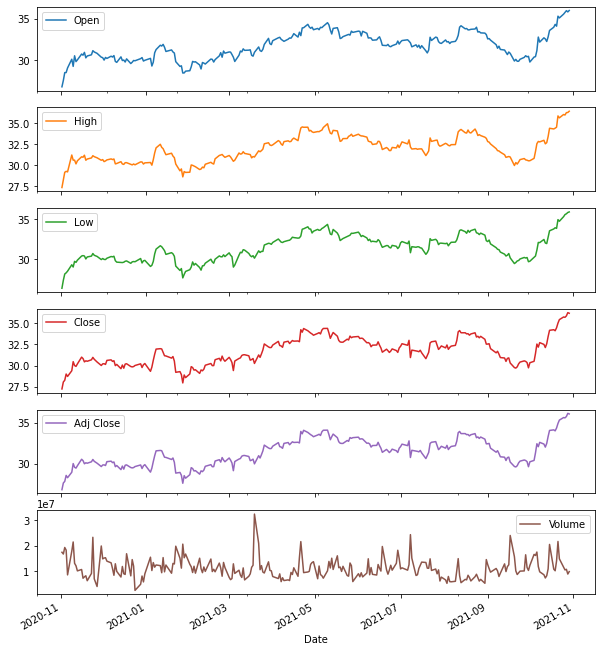

In [50]:
data.plot(figsize=(10, 12), subplots=True)

In [51]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,251.00,251.00,251.00,251.00,251.00,251.00
mean,31.70,32.01,31.42,31.70,31.46,11318806.77
std,1.65,1.62,1.67,1.65,1.70,3989099.54
min,26.78,27.37,26.42,27.25,26.87,2629200.00
25%,30.38,30.69,30.16,30.45,30.18,8692200.00
50%,31.71,31.97,31.45,31.70,31.55,10596600.00
75%,32.80,33.08,32.55,32.84,32.62,13067700.00
max,36.02,36.45,35.92,36.24,36.15,32357400.00


In [52]:
ADJ = data[['Adj Close']]
ADJ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2020-11-02 to 2021-10-29
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  251 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [53]:
ADJ.describe().round(2)

,Adj Close
count,251.00
mean,31.46
std,1.70
min,26.87
25%,30.18
50%,31.55
75%,32.62
max,36.15


array([<AxesSubplot:xlabel='Date'>], dtype=object)

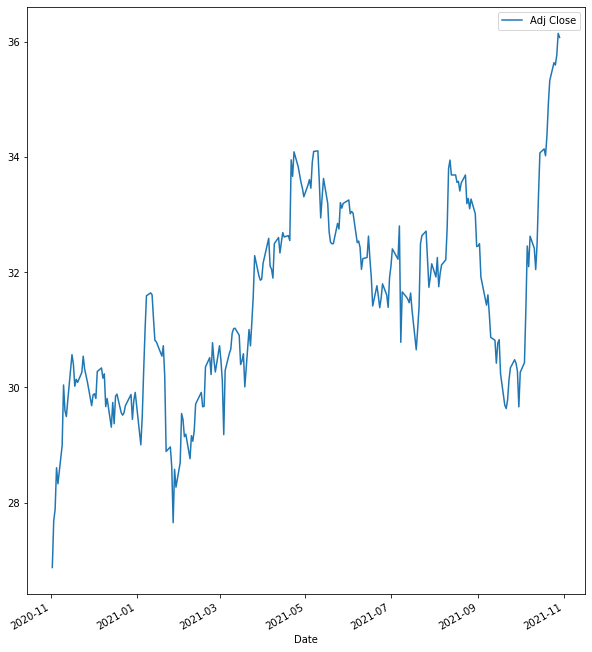

In [54]:
ADJ.plot(figsize=(10, 12), subplots=True)

In [55]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [56]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 22.24 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

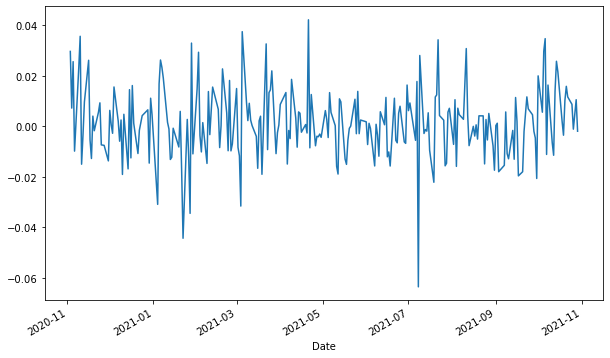

In [59]:
log_return.dropna(inplace=True)
log_return.plot(subplots=True, figsize=(10, 6))

In [67]:
pd.plotting.scatter_matrix(log_return, alpha=0.2, diagonal='hist', hist_kwds={'bins': 35}, figsize=(10, 6))

AttributeError: 'Series' object has no attribute 'columns'

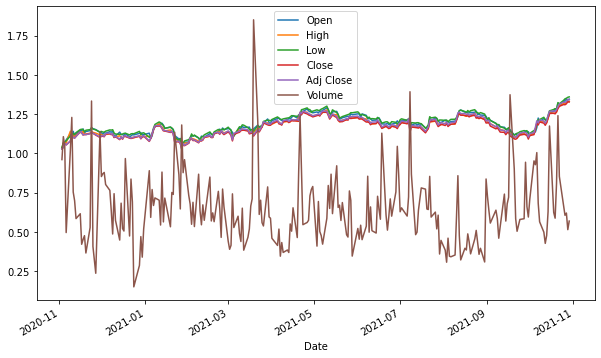

In [65]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6));

# Binomial Tree Methodology

In [29]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 36.08


In [37]:
S0 = 36.08              # spot stock price
K = 32.00               # strike
T = 1.0                 # maturity 
r = 0.0144                 #10 year risk free rate surced from Bloomberg on 02/12/2021 at 4:26pm
sig = 0.2224               # diffusion coefficient or volatility annualized.
q = 0.0108              # Forward dividend and yield sourced from yahoofinance on 02/12/2021 at 4:29pm.
N = 3                   # number of periods or number of time steps  
payoff = "call"          # payoff 

In [38]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [39]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [40]:
S

array([[36.08      , 41.02334911, 46.64399036, 53.03472007],
       [ 0.        , 31.73232874, 36.08      , 41.02334911],
       [ 0.        ,  0.        , 27.90855564, 31.73232874],
       [ 0.        ,  0.        ,  0.        , 24.5455505 ]])

In [24]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.48662809757895575

In [25]:
q

0.5133719024210442

In [26]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        , 21.03472007],
       [ 0.        ,  0.        ,  0.        ,  9.02334911],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [27]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 5.63317716,  9.39895022, 14.79722231, 21.03472007],
       [ 0.        ,  2.11637633,  4.36998884,  9.02334911],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [28]:
print('European ' + payoff, str( V[0,0]))

European call 5.6331771567182525


# Black Scholes Methodology

In [41]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [43]:
euro_option_bsm(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')

5.497200964228483

In [44]:
T = np.linspace(0.25,3,12)
cpd = np.zeros((len(T),1))
for i in range(len(T)):
    cpd [i] = euro_option_bsm(36.08, 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

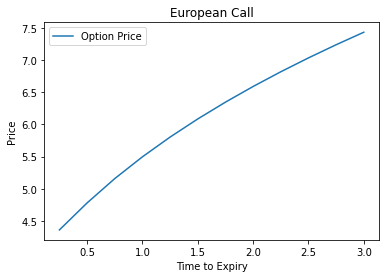

In [45]:
fig = plt.figure()
plt.plot(T, cpd, '-')
plt.xlabel('Time to Expiry')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price'])

# Greeks

# 1. Delta

In [46]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- q * T) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

In [51]:
S = np.linspace(30, 50, 10)
T = np.linspace(0.5, 2, 10)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

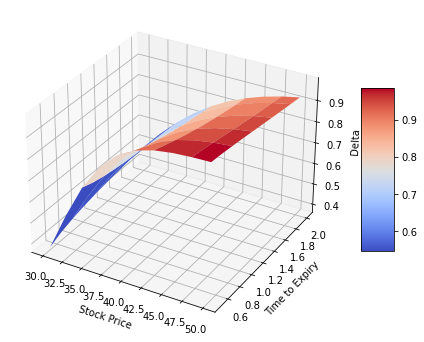

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [53]:
d = delta(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

The value of Delta is 0.7396 . If the stock price increase 1 dollar, then the value of the option will increase $ 0.7396 .


# 2. Gamma

In [61]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [62]:
gamma(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call'

0.0392335654966138

In [63]:
S = np.linspace(30,50,10)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')

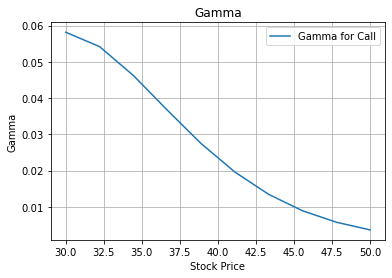

In [65]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call'])

In [67]:
S = np.linspace(30, 50, 10)
T = np.linspace(0.5, 2, 10)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

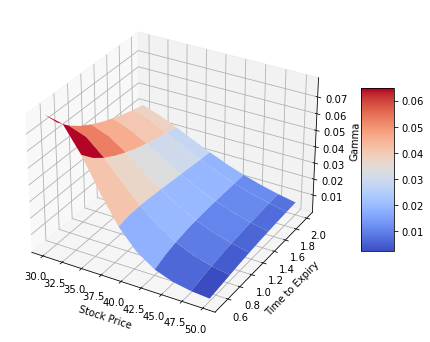

In [68]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# 3. Vega

In [69]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [70]:
S = np.linspace(30, 50, 10)
T = np.linspace(0.5, 2, 10)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

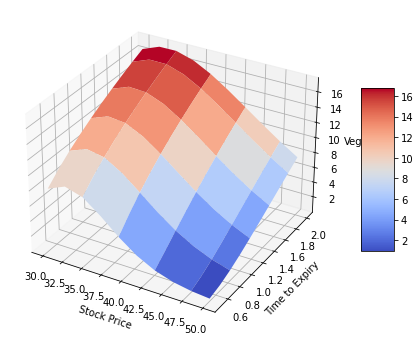

In [71]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [72]:
v = vega(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

The value of Vega is 11.3996 . If the volatility increases 1%, then the value of the option will increase $ 0.113996 .


# 4. Theta

In [73]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [74]:
S = np.linspace(30, 50, 10)
T = np.linspace(0.5, 2, 10)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

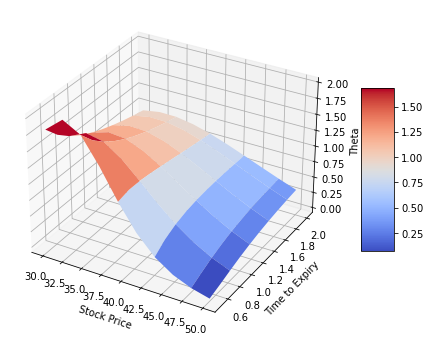

In [75]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [81]:
theta(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')

1.2845359285600524

# 5. Rho

In [83]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [84]:
S = np.linspace(30, 50, 10)
T = np.linspace(0.5, 2, 10)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 32.00, T[i], 0.0144, 0.0108, 0.2224, 'call')

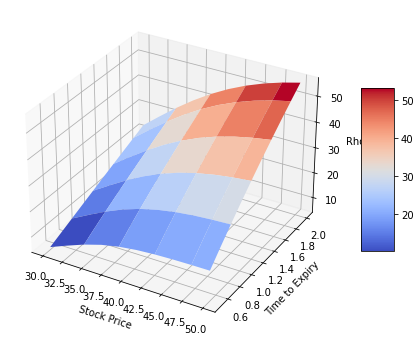

In [85]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [86]:
rho(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')

21.186593646948655

In [88]:
r = rho(36.08, 32.00, 1, 0.0144, 0.0108, 0.2224, 'call')
print('The value of Rho is', r.round(4),'.','If the interest rate increases 1%, then the value of the option will increase by $', r.round(4)*0.01, '.')

The value of Rho is 21.1866 . If the interest rate increases 1%, then the value of the option will increase by $ 0.211866 .
